In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 

In [3]:
#set paths 
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"

VER_2020 = "/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv"
VER_2021 = "/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2021/labels_all.tab"

In [4]:
stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

<ipython-input-4-7444354899f0>:2: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [5]:
merged = pd.merge(artDf, stormsDf[['key','20000_90_average_pct','20000_90_num_over_cutoff',\
                          '20000_90_storm_source', '20000_90_storm']], on="key", how="left")

In [6]:
SCOL = "20000_90"

In [7]:
stormRows = merged.loc[merged[SCOL + "_storm"] == True]

In [8]:
stormRows["date"] = pd.to_datetime(stormRows["date"])

<ipython-input-8-df3dd340f2f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stormRows["date"] = pd.to_datetime(stormRows["date"])


In [9]:
from tqdm import tqdm

In [10]:
artEdges = {}
sourceEdges = {}

WINDOW = 3
currVal = 47806.0

for currVal in tqdm(list(stormRows[SCOL].unique())): 

    currStorm = stormRows.loc[stormRows[SCOL] == currVal, ["date", "key", "source"]].set_index("date")
    minDay = min(currStorm.index)
    maxDay = max(currStorm.index)

    #get all of the starting dates for the date windows we need 
    possibleDates = pd.date_range(minDay, maxDay -  np.timedelta64(WINDOW-1, "D"),freq='d')

    for date in possibleDates: 


        #get rows in our date time range 
        dateRows = currStorm[date : date + np.timedelta64(WINDOW-1, "D")]

        for i in range(len(dateRows)): 
            for j in range(i+1, len(dateRows)):
                l = dateRows.iloc[i]
                r = dateRows.iloc[j]

                #if we haven't already counted this edge 
                artTup = (l["key"], r["key"])
                if artTup not in artEdges: 

                    #if this edge isn't in source dict add it
                    #else, add 1 to its edge 
                    sTup = (l["source"], r["source"])
                    if sTup not in sourceEdges: 
                        sourceEdges[sTup] = 1
                    else: 
                        sourceEdges[sTup] += 1

                    artEdges[artTup] = True


100%|██████████| 98/98 [08:26<00:00,  5.17s/it]


In [11]:
#get sources, veracity scores in a dataframe
ver2020 = pd.read_csv(VER_2020, sep=",")
ver2021 = pd.read_csv(VER_2021, sep="\t")

In [12]:
#we want [0, 1] -> 2, [2, 3] -> 1, [4, 5] -> 0
ver2021["label"] = pd.cut(ver2021["factuality"], bins=[0, 1.1, 3.1, 5.1], labels=[2, 1, 0]).astype(float)

In [13]:
#fill na in 2021 with 2020 ratings 
sourceDf = pd.merge(ver2020, ver2021[["source","label"]], on="source", how="outer")
sourceDf["label"] = sourceDf["label_y"].fillna(sourceDf["label_x"])

#get local/national labels 
localNat = artDf[["source", "national"]].drop_duplicates()
sourceDf = pd.merge(sourceDf, localNat, on="source", how="outer")

In [14]:
#we want outlets with both local and national classification to be local 
sourceDf = sourceDf.sort_values("national").drop_duplicates(subset=["source"])

In [15]:
sourceDf.loc[(sourceDf["source"] == "charlotteobserver"), ["national"]] = False

In [16]:
#merge everything under the "label" category
#here, 4 means local 
sourceDf.loc[sourceDf["national"] == False, "label"] = 3

#only item with a -1 reliability that matters/is relevant is forbes... 
#should be rated "reliable"
sourceDf.loc[sourceDf["source"] == "forbes", "label"] = 0

#if we have nat/local duplicates, call them local 
sourceDf = sourceDf.sort_values("national").drop_duplicates(subset=["source"])

sourceDf["label"] = sourceDf["label"].fillna(4)

#sanity check 
sourceDf["label"].value_counts()

label
3.0    314
4.0    183
1.0    157
2.0    121
0.0     90
Name: count, dtype: int64

In [17]:
stormRows = pd.merge(stormRows, sourceDf[["source", "label"]], on="source", how="left")

In [18]:
#get edges,weights from our algo above and put in dataframe 
sourceTups = list(sourceEdges.keys())
sourceLeft = [tup[0] for tup in sourceTups]
sourceRight = [tup[1] for tup in sourceTups]
sourceWeights = [sourceEdges[tup] for tup in sourceTups]

edgeDf = pd.DataFrame({"first":sourceLeft, "second":sourceRight, "weight":sourceWeights})
edgeDf = edgeDf.sort_values("weight", ascending=False)

#remove self-edges
edgeDf  = edgeDf[edgeDf["first"] != edgeDf["second"]]

# find edge difference 

In [19]:
#now do this for just four bubbles, one for each type of media 
#grab the top outlets in terms of publishing 

#get top outlets   
CUTOFF = 200
sourceCounts = pd.DataFrame(stormRows[["source"]].value_counts()).reset_index()
topSources = list(sourceCounts.head(CUTOFF)["source"])

#get all edges between top sources 
topEdgeDf = edgeDf[(edgeDf["first"].isin(topSources)) & edgeDf["second"].isin(topSources)]


In [20]:
print(f'Top {CUTOFF} outlets in storms:')
print(f'min stories published {min(sourceCounts.head(CUTOFF)["count"])}')
print(f'max stories published {max(sourceCounts.head(CUTOFF)["count"])}')

Top 200 outlets in storms:
min stories published 17
max stories published 750


In [21]:
sourcePairs = pd.merge(topEdgeDf, sourceDf[["source","label"]], left_on="first", right_on="source").drop(columns=["source"])
sourcePairs = pd.merge(sourcePairs, sourceDf[["source", "label"]], left_on="second", right_on="source").drop(columns=["source"])

sourcePairs = sourcePairs.drop(columns=["first", "second"]).groupby(["label_x", "label_y"]).agg(sum).reset_index()

sourcePairs = sourcePairs.replace({0:"reliable", 1:"mixed", 2:"unreliable", 3:"local", 4:"national no label"})

In [22]:
#create graph 
G = nx.from_pandas_edgelist(sourcePairs, source="label_x", target="label_y", edge_attr="weight", create_using=nx.DiGraph)

G.remove_edges_from(nx.selfloop_edges(G))

In [23]:
outWeights = []
outDiffs = []
for node in G.nodes():
    totalOut = sum([G.edges[edge[0], edge[1]]["weight"] for edge in G.out_edges([node])])
    totalIn = sum([G.edges[edge[0], edge[1]]["weight"] for edge in G.in_edges([node])])
    outWeights.append(totalOut)
    outDiffs.append(totalOut - totalIn)
    
nx.set_node_attributes(G, dict(zip(G.nodes(), outWeights)), name="outWeight")
nx.set_node_attributes(G, dict(zip(G.nodes(), outDiffs)), name="outDiffs")

In [25]:
#how big exactly are the differences in these links? 
#we want to try scaling the edges by their number of stories 
for edge in nx.edges(G): 
    thisEdge = G.edges[edge[0], edge[1]]["weight"]
    oppEdge = G.edges[edge[1], edge[0]]["weight"]
    print(f"{edge[0]} - {edge[1]} = {thisEdge} - {oppEdge} = {thisEdge - oppEdge}")
    

reliable - mixed = 81459 - 79791 = 1668
reliable - unreliable = 13660 - 11742 = 1918
reliable - local = 108017 - 107932 = 85
reliable - national no label = 30664 - 27147 = 3517
mixed - reliable = 79791 - 81459 = -1668
mixed - unreliable = 20153 - 18205 = 1948
mixed - local = 114669 - 116711 = -2042
mixed - national no label = 37385 - 33932 = 3453
unreliable - reliable = 11742 - 13660 = -1918
unreliable - mixed = 18205 - 20153 = -1948
unreliable - local = 16569 - 19335 = -2766
unreliable - national no label = 6203 - 6064 = 139
local - reliable = 107932 - 108017 = -85
local - mixed = 116711 - 114669 = 2042
local - unreliable = 19335 - 16569 = 2766
local - national no label = 45881 - 40792 = 5089
national no label - reliable = 27147 - 30664 = -3517
national no label - mixed = 33932 - 37385 = -3453
national no label - unreliable = 6064 - 6203 = -139
national no label - local = 40792 - 45881 = -5089


# Set up Null Model 

In [26]:
def getEdgeDf(sourceEdges): #get edges,weights from our algo above and put in dataframe 
    sourceTups = list(sourceEdges.keys())
    sourceLeft = [tup[0] for tup in sourceTups]
    sourceRight = [tup[1] for tup in sourceTups]
    sourceWeights = [sourceEdges[tup] for tup in sourceTups]

    edgeDf = pd.DataFrame({"first":sourceLeft, "second":sourceRight, "weight":sourceWeights})
    edgeDf = edgeDf.sort_values("weight", ascending=False)

    #remove self-edges
    edgeDf  = edgeDf[edgeDf["first"] != edgeDf["second"]]
    
    return edgeDf 

In [27]:
#get top outlets   
CUTOFF = 200
sourceCounts = pd.DataFrame(stormRows[["source"]].value_counts()).reset_index()
topSources = list(sourceCounts.head(CUTOFF)["source"])


In [28]:
WINDOW = 3
N_ITERS = 20

#IMPORTANT: stores null edge weights 
nullEdgeCounts = {}
    
for i in range(N_ITERS): 
    
    nullArtEdges = {}
    nullSourceEdges = {}

    for currVal in tqdm(list(stormRows[SCOL].unique())): 

        currStorm = stormRows.loc[stormRows[SCOL] == currVal, ["date", "key", "source"]].set_index("date")
        minDay = min(currStorm.index)
        maxDay = max(currStorm.index)


        #this has the effect of shuffling the rows of the dataframe 
        shuffled = currStorm.sample(frac=1)

        #now we give the shuffled dataframe the date values, so 
        #we can treat everything as normal but we have random ordering of stories 
        shuffled = shuffled.set_index(currStorm.sort_values("date").index)

        #get all of the starting dates for the date windows we need 
        possibleDates = pd.date_range(minDay, maxDay -  np.timedelta64(WINDOW-1, "D"),freq='d')

        for date in possibleDates: 

            #get rows in our date time range 
            dateRows = shuffled[date : date + np.timedelta64(WINDOW-1, "D")]

            for i in range(len(dateRows)): 
                for j in range(i+1, len(dateRows)):
                    l = dateRows.iloc[i]
                    r = dateRows.iloc[j]

                    #if we haven't already counted this edge 
                    artTup = (l["key"], r["key"])
                    if artTup not in nullArtEdges: 

                        #if this edge isn't in source dict add it
                        #else, add 1 to its edge 
                        sTup = (l["source"], r["source"])
                        if sTup not in nullSourceEdges: 
                            nullSourceEdges[sTup] = 1
                        else: 
                            nullSourceEdges[sTup] += 1

                        nullArtEdges[artTup] = True
    
    #beginning of code to get null distribution of edge weights
    nullEdgeDf = getEdgeDf(nullSourceEdges)

    #get all edges between top sources 
    topEdgeDf = nullEdgeDf[(nullEdgeDf["first"].isin(topSources)) & nullEdgeDf["second"].isin(topSources)]

    #get the veracity labels 
    sourcePairs = pd.merge(topEdgeDf, sourceDf[["source","label"]], left_on="first", right_on="source").drop(columns=["source"])
    sourcePairs = pd.merge(sourcePairs, sourceDf[["source", "label"]], left_on="second", right_on="source").drop(columns=["source"])
    
    #groupy by veracity label 
    sourcePairs = sourcePairs.drop(columns=["first", "second"]).groupby(["label_x", "label_y"]).agg(sum).reset_index()
    sourcePairs = sourcePairs.replace({0:"reliable", 1:"mixed", 2:"unreliable", 3:"local", 4:"national no label"})
    
    #create graph 
    nullG = nx.from_pandas_edgelist(sourcePairs, source="label_x", target="label_y", edge_attr="weight", create_using=nx.DiGraph)
    nullG.remove_edges_from(nx.selfloop_edges(G))


    for edge in nullG.edges():
        weight = nullG[edge[0]][edge[1]]["weight"]
        if edge not in nullEdgeCounts: 
            nullEdgeCounts[edge] = [weight]
        else: 
            nullEdgeCounts[edge].append(weight)
        
    if i <= 5: 
        print(nullEdgeCounts)
        

100%|██████████| 98/98 [08:16<00:00,  5.06s/it]


In [39]:
#just some helpful code for after 
#how big exactly are the differences in these links? 
#we want to try scaling the edges by their number of stories 
for edge in list(G.edges()): 
    
    thisEdge = G.edges[edge[0], edge[1]]["weight"]
    oppEdge = G.edges[edge[1], edge[0]]["weight"]
    print(f"{edge[0]} - {edge[1]} = {thisEdge} - {oppEdge} = {thisEdge - oppEdge}")
    
    edgeList = nullEdgeCounts[edge]
    oppEdgeList = nullEdgeCounts[(edge[1], edge[0])]
     
    print([edgeList[i] - oppEdgeList[i] for i in range(len(edgeList))])
    

reliable - mixed = 81459 - 79791 = 1668
[2413, -2171, 2022, -441, -1686, -1628, -1724, 1195, 706, 2109, 1156, 4191, -1561, -420, -49, -717, -2746, -3836, -219, -1544]
reliable - unreliable = 13660 - 11742 = 1918
[1043, -168, -1427, -703, 145, 130, -74, 647, -228, 245, 103, 122, 1323, 220, 152, 50, 483, -341, 605, -292]
reliable - local = 108017 - 107932 = 85
[-733, 2075, 4792, -2321, -808, -805, -3393, -2691, 135, 1850, 3364, 5091, -3131, -1762, 3101, 342, 12, -3704, -1576, 769]
reliable - national no label = 30664 - 27147 = 3517
[1965, -674, 1310, -1002, 0, 863, -813, -460, -2057, 656, -189, 356, 33, 847, -848, -1086, 303, 573, -1305, 1026]
mixed - reliable = 79791 - 81459 = -1668
[-2413, 2171, -2022, 441, 1686, 1628, 1724, -1195, -706, -2109, -1156, -4191, 1561, 420, 49, 717, 2746, 3836, 219, 1544]
mixed - unreliable = 20153 - 18205 = 1948
[1005, 670, -2132, -1353, 657, 393, 297, 660, -337, 417, -319, -364, 1347, 674, 159, 11, 1440, -310, 782, 141]
mixed - local = 114669 - 116711 = -

(array([2., 5., 3., 1., 1., 2., 4., 1., 0., 1.]),
 array([-2530. , -1824.4, -1118.8,  -413.2,   292.4,   998. ,  1703.6,
         2409.2,  3114.8,  3820.4,  4526. ]),
 <BarContainer object of 10 artists>)

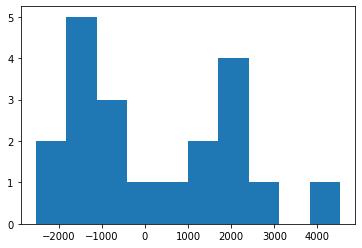

In [40]:
plt.hist([edgeList[i] - oppEdgeList[i] for i in range(len(edgeList))])

In [ ]:
#now we'd like to look at examples 

In [ ]:
#also check in on the dates for revision 